# Assortative Matching With Coarse Types: Chi-Square Estimator of Deep Parameters given Stochastic Classification of Economics Departments by Placement Rates

James Yu, 27 November 2021

## VERSION: $n_i$ and $m_i$ endogenous

In [2]:
INSTALL_PACKAGES = false   # change this to true if you are running this notebook for the first time
YEAR_INTERVAL = 2015:2020  # change this to select the years of data to include in the estimation
NUMBER_OF_TYPES = 4        # change this to select the number of types to classify academic departments into
NUMBER_OF_SINKS = 1        # change this to 4 to use individual sink types
TOTAL_DISTRIBUTIONS = NUMBER_OF_TYPES + NUMBER_OF_SINKS;

In [3]:
import Pkg
for package in ["BlackBoxOptim", "Distributions", "ForwardDiff", "JSON", "Optim", "Quadrature", "StatsPlots"]
    if INSTALL_PACKAGES
        Pkg.add(package)
    end
end
using BlackBoxOptim, Distributions, ForwardDiff, JSON, Optim, Quadrature, StatsPlots

There are two components to this notebook. The first is an algorithm for classifying Economics departments into a series of types based on placement outcome data.

The placement data used is grouped as a dictionary of applicants sorted by year of starting application. In total, the data spans from 2003 to 2021. The procedure for compiling the data is provided in a separate Python file.

In [4]:
year_by_year = JSON.parsefile("to_from_by_year.json")
print(sort(collect(keys(year_by_year))))

["2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]

For our estimation, we will only consider placements from 2015 to 2020 as the number of reported graduates on EconJobMarket was the most stable and even over this period. We put all placement outcomes for Assistant Professor positions in one set, and all other placement outcomes in another set. The other placement outcomes are those where applicants were hired at departments that do not graduate Ph.D. students; this includes the public sector, private sector, government, non-academic positions at academic departments and teaching universities, among others.

In [5]:
i = 0

academic_builder = Set{}()
sink_builder = Set{}()
oid_mapping = Dict{}()
for key in YEAR_INTERVAL
    data = year_by_year[string(key)]
    println(key, " has ", length(keys(data)), " entries")
    for aid in keys(data)
        outcome = data[aid]
        oid_mapping[string(outcome["to_oid"])] = outcome["to_name"]
        oid_mapping[outcome["from_oid"]] = outcome["from_institution_name"]
        if outcome["position_name"] == "Assistant Professor"
            push!(academic_builder, outcome)
        else
            push!(sink_builder, outcome)
        end
    end
end
println(length(academic_builder), " total assistant professor outcomes")
println(length(sink_builder), " other outcomes")

2015 has 512 entries
2016 has 1145 entries
2017 has 837 entries
2018 has 912 entries
2019 has 1002 entries
2020 has 847 entries
3608 total assistant professor outcomes
1647 other outcomes


This piece of code deals with teaching universities by checking if they ever graduated Ph.D. students:

In [6]:
academic = Set{}()
academic_to = Set{}()
for outcome in academic_builder
    push!(academic, outcome["from_institution_name"])
    push!(academic_to, outcome["to_name"])
end

tch_sink = Set{}() # sink of teaching universities that do not graduate PhDs
for key in academic_to
    if !(key in academic)
        push!(tch_sink, key)
    end
end

println(length(academic))
println(length(academic_to))
println(length(tch_sink))

361
801
494


The next piece of code sorts all the sink departments (except teaching universities, which are dealt with above) by category:

In [7]:
filter_sink_builder = Set{}()
for outcome in sink_builder
    if outcome["from_institution_name"] in academic
        push!(filter_sink_builder, outcome)
    end
end

acd_sink = Set{}()
gov_sink = Set{}()
pri_sink = Set{}()

for outcome in filter_sink_builder
    # CODE global academic, other_placements, pri_sink, gov_sink, acd_sink
    if outcome["recruiter_type"] in [6, 7]
        # private sector: for and not for profit
        push!(pri_sink, string(outcome["to_name"], " (private sector)"))
    elseif outcome["recruiter_type"] == 5
        # government institution
        push!(gov_sink, string(outcome["to_name"], " (public sector)"))
    else
        # everything else including terminal academic positions
        push!(acd_sink, string(outcome["to_name"], " (academic sink)"))
    end
end

println(length(acd_sink))
println(length(gov_sink))
println(length(pri_sink))

205
91
102


Now that we have five sets for every category of department, we can construct a matrix representing the placements between these departments:

In [8]:
institutions = vcat(collect(academic), collect(acd_sink), collect(gov_sink), collect(pri_sink), collect(tch_sink))

out = zeros(Int64, length(institutions), length(collect(academic)))
i = 0
for outcome in academic_builder
    i += 1
    out[findfirst(isequal(outcome["to_name"]), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end
for outcome in filter_sink_builder
    i += 1
    keycheck = ""
    if outcome["recruiter_type"] in [6, 7]
        keycheck = string(outcome["to_name"], " (private sector)")
    elseif outcome["recruiter_type"] == 5
        keycheck = string(outcome["to_name"], " (public sector)")
    else
        keycheck = string(outcome["to_name"], " (academic sink)")
    end
    out[findfirst(isequal(keycheck), institutions), findfirst(isequal(outcome["from_institution_name"]), institutions)] += 1
end
println("Total number of outcomes: ", i)

Total number of outcomes: 5156


Finally, we get to the estimator. For this estimate, we assume that each observed set of placement outcomes between any two pairs of departments is drawn from a distribution common to the "type" of the hiring department and the "type" of the graduating department. Here this distribution is assumed to be Poisson, in line with classical stochastic block models used for similar estimations in Karrer and Newman (2011) and Peixoto (2014).

Given a particular assignment of departments to types, and given the placement outcomes, a single round of estimation computes the mean number of applicants from any single type $t$ department that would be hired at a single type $t^\prime$ department and measures the probability that each independent observation was drawn from its corresponding mean. When summed together, the logarithms of the probabilities form a log-likelihood which can be used for maximum likelihood estimation.

In [9]:
function bucket_estimate(assign::Array{Int64}, A::Matrix{Int64}, num, numsink)
    b = zeros(Int64, size(A)[1], size(A)[2])
    T = zeros(num + numsink, num)
    count = zeros(num + numsink, num)
    for i in 1:size(A)[1], j in 1:size(A)[2]
         @inbounds val = (num + 1) * (assign[j] - 1) + assign[i]
         @inbounds b[i, j] = val
         @inbounds T[val] = ((T[val] * count[val]) + A[i, j]) / (count[val] + 1)
         @inbounds count[val] += 1
    end
    L = 0.0
    @simd for i in eachindex(A)
        @inbounds L += logpdf(Poisson(T[b[i]]), A[i])
    end
    return -L, T
end

bucket_estimate (generic function with 1 method)

Finally, we compute the maximum-likelihood estimated Poisson means by stochastically re-allocating departments to types and saving likelihood-improving re-allocations until no further re-allocations are found.

### To skip re-allocating, uncomment the following line instead if you have an allocation already. Do not run the cell after.

In [10]:
est_alloc = JSON.parsefile("type_allocation.json");

In [ ]:
function doit(sample, academic_institutions, asink, gsink, psink, tsink, all_institutions, num, numsink)
    # some initial states
    current_allocation = Array{Int64}(undef, length(all_institutions))
    cur_objective = Inf
    best_mat = nothing
    cursor = 1
    for inst in academic_institutions
        current_allocation[cursor] = 1
        cursor += 1
    end
    # the sinks must stay in fixed types
    # this was built to support more sinks, but by default we only use one
    # change the "current_allocation[cursor] = ..." lines to group sinks together
    for key in asink # other academic
        current_allocation[cursor] = num + min(1, numsink)
        cursor += 1
    end
    for key in gsink # public sector
        current_allocation[cursor] = num + min(2, numsink)
        cursor += 1
    end
    for key in psink # private sector
        current_allocation[cursor] = num + min(3, numsink)
        cursor += 1
    end
    for key in tsink # assistant professor at teaching universities
        current_allocation[cursor] = num + min(4, numsink)
        cursor += 1
    end
    blankcount = 0

    # BEGIN MONTE CARLO REALLOCATION ROUTINE
    while true
        # attempt to reallocate academic institutions to a random spot
        temp_allocation = copy(current_allocation)
        k = rand(1:length(academic_institutions))
        @inbounds temp_allocation[k] = rand(delete!(Set(1:num), temp_allocation[k]))
        # check if the new assignment is better
        test_objective, estimated_means = bucket_estimate(temp_allocation, sample, num, numsink)
        if test_objective < cur_objective
            print(test_objective, " ")
            blankcount = 0
            cur_objective = test_objective
            best_mat = estimated_means
            current_allocation = temp_allocation
        else
            blankcount += 1
            if blankcount % 1000 == 0
                print(blankcount, " ")
            end
        end
        if blankcount == 100000
            return cur_objective, best_mat, current_allocation
        end
    end
end

est_obj, est_mat, est_alloc = doit(out, collect(academic), collect(acd_sink), collect(gov_sink), collect(pri_sink), collect(tch_sink), institutions, NUMBER_OF_TYPES, NUMBER_OF_SINKS)

The resulting allocation of departments to types can be found at the end of this notebook.

In [11]:
function bucket_extract(assign, A::Matrix{Int64}, num, numsink)
    T = zeros(Int64, num + numsink, num)
    for i in 1:size(A)[1], j in 1:size(A)[2]
         @inbounds T[(num + 1) * (assign[j] - 1) + assign[i]] += A[i, j]
    end
    return T
end

bucket_extract (generic function with 1 method)

The estimated means are:

In [12]:
est_mat = bucket_extract(est_alloc, out, NUMBER_OF_TYPES, NUMBER_OF_SINKS)

5×4 Matrix{Int64}:
  333   79   15    9
  346  211   55   20
  448  422  238   27
   51   76   48   54
 1044  917  584  179

The matrix is then ordered such that, for any two elements in symmetric positions across the diagonal, the element below the diagonal is greater than the element above the diagonal. For example, the 204 in cell (1, 2) is greater than the 50 in the symmetric cell (2, 1) below, as are all the other symmetric pairs.

For small numbers of types (e.g. 4), the number of applicants of each type that are in the sink type usually correlates with this order.

In [13]:
sink_sum = sum(est_mat[i, :] for i in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS)
indices_of_greatest_elements = sortperm(sink_sum, rev = true)
order = zeros(Int64, length(sink_sum))
for i in 1:length(sink_sum)
    order[indices_of_greatest_elements[i]] = i
end
for i in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS
    push!(order, i)
end
order

5-element Vector{Int64}:
 1
 2
 3
 4
 5

In [14]:
# order = [3 2 4 1 5] 
# uncomment the line and replace with your own order if using a large amount of types,
# and if the number of applicants in the sinks no longer becomes representative of the order

In [15]:
placement_rates = zeros(Int64, (TOTAL_DISTRIBUTIONS, NUMBER_OF_TYPES))

for i in 1:TOTAL_DISTRIBUTIONS, j in 1:NUMBER_OF_TYPES
    placement_rates[order[i], order[j]] = est_mat[i, j]
end
placement_rates

5×4 Matrix{Int64}:
  333   79   15    9
  346  211   55   20
  448  422  238   27
   51   76   48   54
 1044  917  584  179

To verify that this is ordered properly, we can check symmetric indices:

In [16]:
for i in 1:NUMBER_OF_TYPES, j in 1:NUMBER_OF_TYPES
    if i > j # not a diagonal and only check once
        if placement_rates[i, j] <= placement_rates[j, i]
            println("FAULT: hiring ", i, " with graduating ", j, ": downward rate: ", placement_rates[i, j], ", upward rate: ", placement_rates[j, i])
        end
    end
end
println("Check Complete")

Check Complete


If everything worked fine, there should be no faults in this cell. If there are, change the order in the cell with the explicit order.

Next, we construct a numerical global minimizer for the chi-squared metric of differences between the above placement rates and a set of theoretically-predicted rates given by values $v_i$ and offer distributions $F_i(x)$. 

We start by constructing the equations which give the theoretical probabilities. Each uses the same notation and indices as in the theory. For $F_i(x)$, we use the two-parameter truncated normal distribution with support on $[0, 1]$.

In [17]:
# define p_vec as
# [v2/v1 v3/v2 v4/v3 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]
# let T = 4
# let S = 1
# then p_vec[i + T - 1] = p_vec[i + 3] for i:1..5 gives mu
# then p_vec[i + T - 1 + T + S] = p_vec[i + 3 + 5] for i:1..5 gives sigma
# then p_vec[i] for i:1..3 gives vi/vj

# truncated normal: https://juliastats.org/Distributions.jl/stable/truncate/#Distributions.TruncatedNormal

function pi_t_(pi_t_minus_1, v_ratio_t, m_t_minus_1, m_t, n)
    return pi_t_minus_1 / (pi_t_minus_1 + ((v_ratio_t ^ (1 / (n - 1))) * m_t_minus_1 / m_t))
end

function F_x_t_(Fx_t_minus_1, pi_t, m_t, v_ratio_t, n)
    return Fx_t_minus_1 - ((m_t / pi_t) * (1 - (v_ratio_t ^ (1 / (n - 1)))))
end

function f_i_x_t_(x, p_vec, i, T, S)
    return pdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x)
end

function F_(x, p_vec, n_vec, n, T, S)
    return sum([(n_vec[i] / n) * cdf(TruncatedNormal(p_vec[i + T - 1], p_vec[i + T - 1 + T + S], 0, 1), x) for i in 1:T+S])
end

function Q_ts_(Fx, Fx_vec, pi_vec, m_vec, n, t, s)
    # pi_vec = [1, pi2, pi3, ...]
    # Fx_vec = [1, Fx1, Fx2, ...]
    # Fx_vec[s] = F(x_{s-1})
    target = ((Fx_vec[s] - Fx) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:s]) / m_vec[t]) 
    subtractor = sum([(Fx_vec[k] - Fx_vec[k + 1]) * pi_vec[t] * prod([(1.0 - pi_vec[i]) for i in t+1:k]) / m_vec[t] for k in t:s-1])
    return (1.0 - target - subtractor) ^ (n - 1.0)
end

# numerical integration docs: https://juliapackages.com/p/quadrature
function h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
    # x_vec = [x0, x1, x2, ...]
    # x_vec[s] = x_{s-1}
    return sum([pi_vec[t] * prod([(1.0 - pi_vec[j]) for j in t+1:s]) * solve(QuadratureProblem((x, p) -> Q_ts_(F_(x, p, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s) * f_i_x_t_(x, p, i, T, S), x_vec[s + 1], x_vec[s], p_vec), HCubatureJL())[1] for s in t:T])
end

h_it_ (generic function with 1 method)

Finally, the chi-square estimator is constructed using the theoretical equations and the observed data.

In [21]:
# at one point this method was based on 
# https://discourse.julialang.org/t/a-hacky-guide-to-using-automatic-differentiation-in-nested-optimization-problems/39123
# though has since evolved to not use autodifferentiation in the outer optimizer, which turns out to be faster

# optimization reference: https://julianlsolvers.github.io/Optim.jl/stable/#user/minimization/
# this reference also references the global minimizer used for the outer optimizer: 
# https://github.com/robertfeldt/BlackBoxOptim.jl
function chisquare(p_vec, T, S, placements, years, start_n, start_m)
    n_vec = p_vec[start_n:start_n+T+S-1]
    m_vec = p_vec[start_m:start_m+T-1]
    n = sum(n_vec)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
    end
    
    objective = 0.0
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        mean = n_vec[i] * years * h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    return objective
end

# upper bound on the value ratios, which should all be less than 1
# if any ratio turns out to be 1.0 or close to it at optimality, this could indicate that a lower tier has a higher value than a higher one
upper = [1.0 for i in 1:NUMBER_OF_TYPES-1] 

# upper bound on the mu parameter of truncated normal, which is strictly within [0, 1] as the mean is greater than mu in truncated normal
append!(upper, [1.0 for i in 1:TOTAL_DISTRIBUTIONS])

# reasonable upper bound on the sigma parameter of truncated normal
# if any parameter estimate is close to this at optimality, make the upper bound higher
append!(upper, [10.0 for i in 1:TOTAL_DISTRIBUTIONS])

# n_i
start_n = length(upper) + 1
append!(upper, [2000.0 for i in 1:NUMBER_OF_TYPES+NUMBER_OF_SINKS])

# m_i
start_m = length(upper) + 1
append!(upper, [2000.0 for i in 1:NUMBER_OF_TYPES])

# all lower bounds are zero as these should be positive parameters
res = bboptimize(p -> chisquare(p, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL)), start_n, start_m), SearchRange = [(0.0, upper[i]) for i in 1:length(upper)], MaxFuncEvals = 100000)
sol = best_candidate(res)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 275 evals, 179 steps, improv/step: 0.408 (last = 0.4078), fitness=3580.384365812
1.00 secs, 555 evals, 426 steps, improv/step: 0.373 (last = 0.3482), fitness=3109.110879420
1.51 secs, 864 evals, 733 steps, improv/step: 0.338 (last = 0.2899), fitness=2603.726631816
2.01 secs, 1166 evals, 1035 steps, improv/step: 0.296 (last = 0.1921), fitness=2038.809901392
2.51 secs, 1471 evals, 1340 steps, improv/step: 0.270 (last = 0.1836), fitness=1665.478633531
3.04 secs, 1774 evals, 1643 steps, improv/step: 0.263 (last = 0.2310), fitness=1289.804542704
3.54 secs, 2080 evals, 1949 steps, improv/step: 0.254 (last = 0.2092), fitness=992.207106025
4.04 secs, 2378 evals, 2247 steps, improv/step: 0.243 (last = 0.1711), fitness=793.536782973
4.54 secs, 2671 evals, 2540 steps, improv/step: 0.23

22-element Vector{Float64}:
    0.8279489111169193
    0.5099063455277648
    0.10005505901583683
    0.9988532432952961
    0.5099521679954703
    0.4663019183345984
    0.3370713063393168
    0.427707803463449
    0.5575026057555768
    0.18802424147784844
    0.09615732871697578
    0.12493981488131145
    0.11084318568894519
  120.8680362490173
  243.7250310894997
  619.625863775903
  235.70470187346285
 1801.3364025245703
  379.5481184684986
  292.64069276532865
  165.83350675314676
  106.40879586735413

Given the estimate for the global minimum, we can print out some summary metrics:

In [23]:
function print_metrics(p_vec, m_vec, n_vec, n, T, S, placements, years)
    pi_vec = ones(T)
    Fx_vec = ones(T)
    for t in 2:T
        pi_vec[t] = pi_t_(pi_vec[t - 1], p_vec[t - 1], m_vec[t - 1], m_vec[t], n) 
        # note pi_vec = [pi1 = 1, pi2, pi3, pi4] but Fx_vec = [Fx0 = 1, Fx1, Fx2, Fx3] 
        Fx_vec[t] = F_x_t_(Fx_vec[t - 1], pi_vec[t - 1], m_vec[t - 1], p_vec[t - 1], n)
    end
    
    x_vec = ones(T + 1) # x_vec = [x0 = 1, x1, x2, x3, x4 = 0]
    x_vec[T + 1] = 0.0
    min_vec = zeros(T + 1)
    for i in 1:T-1
        packet = optimize(x -> (F_(x[1], p_vec, n_vec, n, T, S) - (Fx_vec[i] - ((m_vec[i] / pi_vec[i]) * (1.0 - (p_vec[i] ^ (1.0 / (n - 1.0))))))) ^ 2, [0.0], [1.0], [0.5], Fminbox(LBFGS()); autodiff = :forward)
        x_vec[i + 1] = Optim.minimizer(packet)[1] # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        min_vec[i + 1] = Optim.minimum(packet)[1]
    end
    
    objective = 0.0
    q_matrix = zeros((T, T))
    h_matrix = zeros(size(placements))
    nh_matrix = zeros(size(placements))
    for i in 1:size(placements)[1], t in 1:size(placements)[2]
        h_for_matrix = h_it_(p_vec, pi_vec, Fx_vec, m_vec, n_vec, x_vec, n, T, S, i, t)
        mean = n_vec[i] * years * h_for_matrix
        h_matrix[i, t] = h_for_matrix
        nh_matrix[i, t] = mean
        objective += (placements[i, t] - mean) ^ 2 / mean
    end
    
    for s in 1:T, t in 1:T
        q_for_matrix = Q_ts_(F_(x_vec[s], p_vec, n_vec, n, T, S), Fx_vec, pi_vec, m_vec, n, t, s)
        q_matrix[s, t] = q_for_matrix
    end
    
    for i in 1:T
        println("pi_", i, " = ", pi_vec[i])
    end
    println()
    for i in 1:T+1
        println("x_", i - 1, " = ", x_vec[i], " (error: ", min_vec[i], ")")
    end
    println()
    for i in 1:T
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    println("objective value = ", objective)
    println()
    println("estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:")
    for i in 1:size(q_matrix)[1]
        println(round.(q_matrix[i, :], digits = 4))
    end
    println()
    println("estimated h_it:")
    for i in 1:size(h_matrix)[1]
        println(round.(h_matrix[i, :], digits = 4))
    end
    println()
    println("estimated placement rates:")
    for i in 1:size(nh_matrix)[1]
        println(round.(nh_matrix[i, :], digits = 4))
    end
    println()
    println("actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(placement_rates[i, :])
    end
    println()
    println("difference between estimated and actual placement rates:")
    for i in 1:size(placement_rates)[1]
        println(round.(nh_matrix[i, :] - placement_rates[i, :], digits = 4))
    end
    println()
    println("chi-square p-value")
    println(1 - cdf(Chisq((size(placement_rates)[1] - 1) * (size(placement_rates)[2] - 1)), objective))
end

n_vec = sol[start_n:start_n+TOTAL_DISTRIBUTIONS-1]
m_vec = sol[start_m:start_m+NUMBER_OF_TYPES-1]
n = sum(n_vec)
print_metrics(sol, m_vec, n_vec, n, NUMBER_OF_TYPES, NUMBER_OF_SINKS, placement_rates, Float64(length(YEAR_INTERVAL)))

pi_1 = 1.0
pi_2 = 0.43537026703701204
pi_3 = 0.19792774519701792
pi_4 = 0.11276667734235199

x_0 = 1.0 (error: 0.0)
x_1 = 0.7527328438313645 (error: 8.483314718684644e-18)
x_2 = 0.5541096635057352 (error: 3.713443792530929e-21)
x_3 = 0.330908361520724 (error: 4.0338404778922197e-20)
x_4 = 0.0 (error: 0.0)

F(x_0) = 1.0
F(x_1) = 0.9762742621247523
F(x_2) = 0.8263958862405817
F(x_3) = 0.18803299970437837

objective value = 8.200124149890467

estimated Q_t(x_s) (rows are offer value from high to low, columns are type in increasing type index:
[1.0, 1.0, 1.0, 1.0]
[0.8279, 1.0, 1.0, 1.0]
[0.4222, 0.5099, 1.0, 1.0]
[0.0422, 0.051, 0.1001, 1.0]

estimated h_it:
[0.4593, 0.1096, 0.02, 0.0126]
[0.2376, 0.1427, 0.0387, 0.0135]
[0.1218, 0.1123, 0.0641, 0.0073]
[0.0474, 0.0438, 0.035, 0.0381]
[0.0948, 0.0869, 0.0538, 0.0166]

estimated placement rates:
[333.1191, 79.4517, 14.5244, 9.1279]
[347.3915, 208.6164, 56.5681, 19.808]
[452.7918, 417.4065, 238.4016, 27.041]
[67.0927, 61.9854, 49.5285, 53.8

The estimated value ratios:

In [24]:
for i in 1:NUMBER_OF_TYPES-1
    println("v_", i + 1, "/v_", i, " = ", sol[i])
end

v_2/v_1 = 0.8279489111169193
v_3/v_2 = 0.5099063455277648
v_4/v_3 = 0.10005505901583683


If we let $v_1 = 1$, then we get:

In [25]:
v_base = 1
for i in 1:NUMBER_OF_TYPES
    println("v", i, ": ", v_base)
    if i != NUMBER_OF_TYPES
        v_base = sol[i] * v_base
    end
end

v1: 1
v2: 0.8279489111169193
v3: 0.42217640355132047
v4: 0.042240884972421115


In [26]:
for select_type in 1:NUMBER_OF_TYPES
    println("mean for type ", select_type, ": ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println("stddev for type ", select_type, ": ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1)))
    println()
end
println("mean for sink: ", mean(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))
println("stddev for sink: ", std(TruncatedNormal(sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS], sol[NUMBER_OF_TYPES-1+TOTAL_DISTRIBUTIONS+TOTAL_DISTRIBUTIONS], 0, 1)))

mean for type 1: 0.6159981577020817
stddev for type 1: 0.2598987390626073

mean for type 2: 0.5093308243393607
stddev for type 2: 0.18203613731925625

mean for type 3: 0.46630221067232447
stddev for type 3: 0.09615657909525001

mean for type 4: 0.3383853510937075
stddev for type 4: 0.12314733179202396

mean for sink: 0.42773358135943973
stddev for sink: 0.11079311253980748


Finally, we can plot the CDFs and PDFs of the distributions:

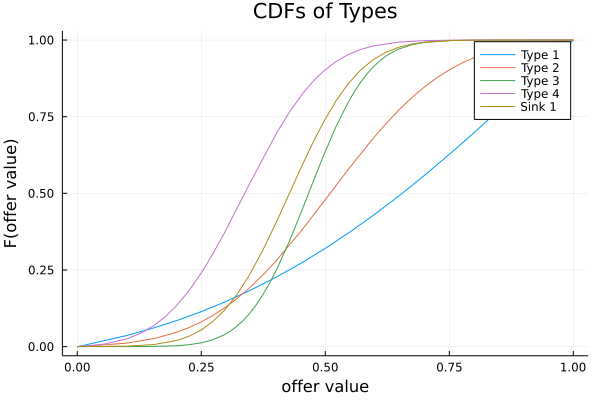

In [27]:
# https://github.com/JuliaPlots/StatsPlots.jl/blob/master/README.md
# https://docs.juliaplots.org/latest/tutorial/

select_type = 1
cdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, title = "CDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(cdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = cdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(cdfs, "offer value")
ylabel!(cdfs, "F(offer value)")
cdfs

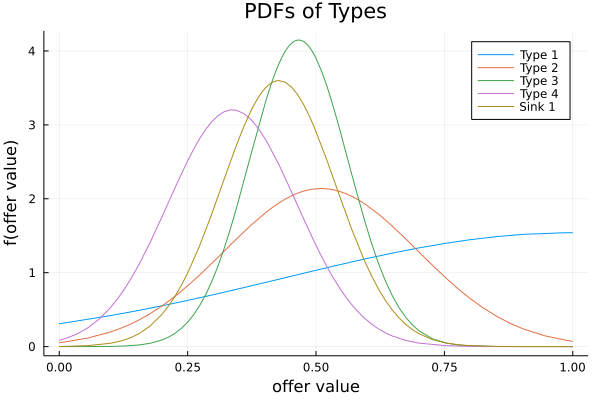

In [28]:
select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

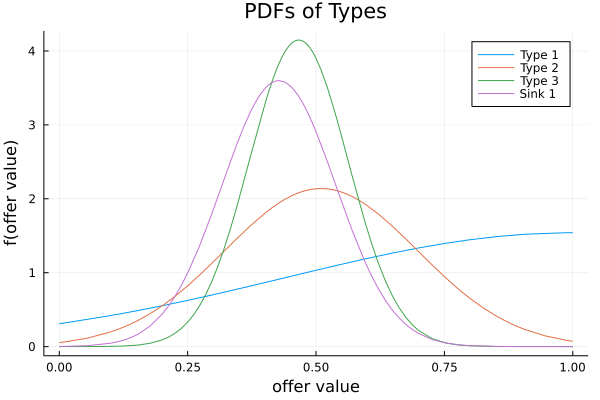

In [29]:
TYPE_TO_DELETE = 4 # change this if you want to remove the pdf of a different academic type; set to zero to not delete any
SINK_TO_DELETE = 0 # change this if you want to remove the pdf of a different sink type

select_type = 1
pdfs = plot(TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, title = "PDFs of Types", label = "Type 1")
for select_type in 2:NUMBER_OF_TYPES # academic types
    if select_type != TYPE_TO_DELETE
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Type ", select_type))
    end
end

for select_type in NUMBER_OF_TYPES+1:TOTAL_DISTRIBUTIONS # sinks
    if select_type != SINK_TO_DELETE + NUMBER_OF_TYPES
        plot!(pdfs, TruncatedNormal(sol[NUMBER_OF_TYPES-1+select_type], sol[NUMBER_OF_TYPES-1+select_type+TOTAL_DISTRIBUTIONS], 0, 1), func = pdf, label = string("Sink ", select_type - NUMBER_OF_TYPES))
    end
end
xlabel!(pdfs, "offer value")
ylabel!(pdfs, "f(offer value)")
pdfs

The actual allocation of departments to types is:

In [30]:
for j in 1:NUMBER_OF_TYPES
    println("TYPE ", j)
    println()
    i = 1
    for entry in est_alloc
        if entry == indices_of_greatest_elements[j]
            println(institutions[i])
        end
        i += 1
    end
    println()
    println()
end

TYPE 1

Columbia University
University of Pennsylvania
University of Wisconsin, Madison
Boston University
New York University
Cornell University
Northwestern University
Ohio State University
University of California, Berkeley
London School of Economics and Political Science
University of Minnesota, Twin Cities
Harvard University
University of California Los Angeles (UCLA)
Yale University
Stanford University
University of Toronto
University of Michigan
Duke University
University of Maryland
Princeton University
University of Chicago


TYPE 2

Rice University
Massachusetts Institute of Technology
University of Rochester
Vrije Universiteit Amsterdam
London Business School
University of Bonn (Rheinische Friedrich-Wilhelms-Universität Bonn)
Syracuse University
University of Arizona
University of California, San Diego
Boston College
University of Warwick
Toulouse School of Economics
University of Virginia
National University of Singapore
University of British Columbia
Maastricht University
U

In [31]:
for j in NUMBER_OF_TYPES+1:NUMBER_OF_SINKS+NUMBER_OF_TYPES
    println("SINK ", j - NUMBER_OF_TYPES)
    println()
    i = 1
    for entry in est_alloc
        if entry == j
            println(institutions[i])
        end
        i += 1
    end
    println()
    println()
end

SINK 1

De Nederlandsche Bank (academic sink)
Institute of Economics (Ekonomski institut), Zagreb (academic sink)
Texas A&M University, College Station (academic sink)
University of Oxford (academic sink)
Centre d'Etudes Prospectives et d'Informations Internationales (CEPII) (academic sink)
University of Sussex (academic sink)
Georgia State University (academic sink)
University of California, San Diego (academic sink)
Lund University (Lunds Universitet) (academic sink)
Centre for Advanced Financial Research And Learning (academic sink)
Dublin City University (academic sink)
Université Paris-Dauphine (academic sink)
Ruhr University Bochum (Ruhr-Universität Bochum) (academic sink)
University of North Carolina, Greensboro (academic sink)
WZB Berlin Social Science Center (Wissenschaftszentrum Berlin für Sozialforschung) (academic sink)
Ohio State University (academic sink)
Florida International University (academic sink)
INSEAD (academic sink)
Boise State University (academic sink)
Duke Un

In [32]:
print(est_alloc)

Any[1, 4, 3, 2, 3, 3, 4, 2, 3, 4, 3, 3, 4, 4, 4, 2, 3, 4, 4, 4, 2, 3, 3, 3, 4, 4, 4, 3, 2, 3, 4, 3, 1, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 3, 3, 3, 2, 1, 4, 2, 4, 2, 1, 2, 3, 1, 3, 4, 4, 2, 4, 2, 2, 3, 4, 4, 3, 3, 4, 4, 4, 3, 3, 2, 2, 1, 2, 4, 3, 4, 2, 3, 2, 3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 4, 2, 4, 3, 3, 4, 4, 4, 3, 3, 4, 3, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 4, 4, 2, 1, 4, 2, 2, 1, 4, 4, 3, 1, 4, 3, 1, 2, 3, 4, 4, 4, 2, 3, 2, 4, 3, 3, 4, 3, 4, 4, 3, 2, 3, 3, 4, 4, 3, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 1, 4, 4, 4, 3, 3, 2, 3, 2, 1, 4, 4, 3, 3, 2, 4, 2, 4, 3, 2, 4, 1, 3, 4, 2, 4, 3, 4, 3, 4, 4, 4, 3, 3, 3, 2, 4, 2, 4, 3, 3, 4, 4, 3, 4, 3, 2, 4, 4, 3, 3, 4, 4, 3, 4, 4, 3, 4, 2, 2, 3, 3, 3, 4, 4, 3, 4, 3, 2, 4, 3, 4, 3, 3, 2, 3, 3, 3, 1, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 4, 4, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 2, 4, 3, 3, 4, 3, 4, 3, 4, 2, 2, 4, 3, 2, 4, 4, 3, 2, 1, 3, 2, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 2, 4, 

## References

Karrer, B., and M. E. J. Newman (2011): "Stochastic Blockmodels and community structure in networks," Physical Review, 83(1).

Peixoto, T. (2014): "Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models," Physical Review, 89(1).